# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [29]:
import os
import re
import emoji
import pandas as pd
import numpy as np
#import nltk

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords
nltk.download('stopwords') 

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


False

In [30]:
# Add any additional import statements you need here
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# change `data_location` to the location of the folder on your machine.
data_location = ""

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [7]:
# Read in the lyrics data

# Paths to lyrics and twitter folders
lyrics_path = os.path.join(data_location, lyrics_folder)
twitter_path = os.path.join(data_location, twitter_folder)

# Print the paths to verify them
print("Lyrics path:", lyrics_path)
print("Twitter path:", twitter_path)

# Check if the directories exist
if not os.path.exists(lyrics_path):
    print(f"Error: Lyrics directory not found at {lyrics_path}")
if not os.path.exists(twitter_path):
    print(f"Error: Twitter directory not found at {twitter_path}")

Lyrics path: lyrics/
Twitter path: twitter/


In [8]:
# Function to read lyrics data into a nested dictionary {artist: {song: lyrics}}
def read_lyrics_data(lyrics_path):
    lyrics_data = defaultdict(dict)  # Nested dictionary {artist: {song: lyrics}}
    
    for artist in os.listdir(lyrics_path):  # Iterate through each artist folder
        artist_folder = os.path.join(lyrics_path, artist)
        
        if os.path.isdir(artist_folder):  # Ensure it's a directory
            for song_file in os.listdir(artist_folder):  # Iterate through each song file
                if song_file.endswith('.txt'):  # Check if it's a .txt file
                    song_title = song_file.replace('.txt', '')
                    with open(os.path.join(artist_folder, song_file), 'r', encoding='utf-8') as f:
                        lyrics = f.read()
                    lyrics_data[artist][song_title] = lyrics  # Store lyrics by artist and song title
    
    return lyrics_data

# Read in the lyrics data
lyrics_data = read_lyrics_data(lyrics_path)

print("Lyrics Data (sample):", {artist: list(lyrics.keys())[:2] for artist, lyrics in lyrics_data.items()})


Lyrics Data (sample): {'robyn': ['robyn_includemeout', 'robyn_electric'], 'cher': ['cher_comeandstaywithme', 'cher_pirate']}


In [34]:
# Read in the twitter data

def read_twitter_data(twitter_path):
    twitter_data = defaultdict(list)  
    
    for artist_file in os.listdir(twitter_path):  # Iterate through each artist file
        if artist_file.endswith('.txt'):  # Check if it's a .txt file
            artist_name = artist_file.replace('.txt', '')
            with open(os.path.join(twitter_path, artist_file), 'r', encoding='utf-8') as f:
                descriptions = f.readlines()  # Read all lines in the text file
                descriptions = [desc.strip() for desc in descriptions if desc.strip()]  # Strip whitespace and ignore empty lines
                twitter_data[artist_name] = descriptions  # Store descriptions by artist
    
    return twitter_data

# Read in the Twitter data
twitter_data = read_twitter_data(twitter_path)
print("Twitter Data (sample):", {artist: twitter_data[artist][:2] for artist in twitter_data})


Twitter Data (sample): {'cher_followers_data': ['screen_name\tname\tid\tlocation\tfollowers_count\tfriends_count\tdescription', 'hsmcnp\tCountry Girl\t35152213\t\t1302\t1014'], 'robynkonichiwa_followers_data': ['screen_name\tname\tid\tlocation\tfollowers_count\tfriends_count\tdescription', 'AngelxoArts\tAngelxo\t1424055675030806529\tZacatlan, Puebla, Mexico\t29\t535\t"I love chill" •Facebook / Instagram / SoundCloud: AngelxoArts• https://t.co/447okKLKzA…'], 'cher_followers': ['id', '35152213'], 'robynkonichiwa_followers': ['id', '1424055675030806529']}


In [10]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Define paths for the positive, negative, and tidytext sentiment files
positive_words_path = os.path.join(data_location, positive_words_file)
negative_words_path = os.path.join(data_location, negative_words_file)
tidytext_path = os.path.join(data_location, tidy_text_file)

def read_sentiment_words(file_path, score):
    words = []
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            word = line.strip()
            # Ignore comments or empty lines
            if word and not word.startswith(";") and not word.startswith("#"):
                words.append((word, score))  # Append the word and its sentiment score
    return words

# Read positive and negative words with corresponding scores
positive_words = read_sentiment_words(positive_words_path, 1)
negative_words = read_sentiment_words(negative_words_path, -1)

# Read tidytext sentiment file
tidytext_df = pd.read_csv(tidytext_path, delimiter="\t", header=None, names=["word", "sentiment"])
tidytext_df['score'] = tidytext_df['sentiment'].apply(lambda x: 1 if x == 'positive' else -1)

# Convert the positive and negative words to DataFrame
pos_neg_df = pd.DataFrame(positive_words + negative_words, columns=["word", "score"])

# Combine the positive/negative words with tidytext sentiment data
combined_sentiments_df = pd.concat([pos_neg_df, tidytext_df[['word', 'score']]], ignore_index=True)

# Remove any duplicate words, keeping the first occurrence
combined_sentiments_df = combined_sentiments_df.drop_duplicates(subset='word').reset_index(drop=True)

print(combined_sentiments_df.head())


        word  score
0         a+      1
1     abound      1
2    abounds      1
3  abundance      1
4   abundant      1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [19]:
def compute_sentiment_score(lyrics, sentiment_lookup):
    tokenized_words = lyrics.split()  # Split the lyrics into words
    total_score = 0 
    for word in tokenized_words:
        clean_word = word.lower().strip(punctuation)  # Clean the word
        total_score += sentiment_lookup.get(clean_word, 0)  # Sum up scores from the sentiment lookup
    return total_score  # Return the final sentiment score

# Calculate sentiment score for each song's lyrics using the function
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(
    lambda lyrics: compute_sentiment_score(lyrics, sentiment_dict)
)

# Print the DataFrame showing artist, song, and calculated sentiment score
print(lyrics_df[['artist', 'song', 'sentiment_score']])

    artist                    song  sentiment_score
0    robyn      robyn_includemeout               -3
1    robyn          robyn_electric               -6
2    robyn         robyn_beach2k20               20
3    robyn         robyn_lovekills              -23
4    robyn       robyn_timemachine               -5
..     ...                     ...              ...
415   cher  cher_takeitfromtheboys               12
416   cher          cher_dreambaby               11
417   cher   cher_pleasedonttellme               -2
418   cher     cher_ihopeyoufindit                2
419   cher       cher_classified1a                3

[420 rows x 3 columns]


### Questions

Q: Overall, which artist has the higher average sentiment per song? 




In [21]:
average_sentiment_per_artist = lyrics_df.groupby('artist')['sentiment_score'].mean()
higher_average_artist = average_sentiment_per_artist.idxmax()
higher_average_score = average_sentiment_per_artist.max()
print(f"Artist with the higher average sentiment per song: {higher_average_artist} (Average Score: {higher_average_score:.2f})")


Artist with the higher average sentiment per song: cher (Average Score: 3.47)


A: Cher has a higher average sentiment per song.

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

In [45]:
first_artist = lyrics_df['artist'].unique()[0]
first_artist_songs = lyrics_df[lyrics_df['artist'] == first_artist]

# Songs with the highest sentiments
highest_sentiment_songs = first_artist_songs.nlargest(3, 'sentiment_score')
lowest_sentiment_songs = first_artist_songs.nsmallest(3, 'sentiment_score')

print(f"\nTop 3 songs with highest sentiment for {first_artist}:")

for index, row in highest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")


Top 3 songs with highest sentiment for robyn:
Song: robyn_loveisfree, Sentiment Score: 102
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom b

A: The three Cher songs with the highest sentiments are 'Love Is Free', 'U Should Know Better', and 'U Should Know Better.' The driving sentiment for these songs seem to be love and vengeance and wild revenge.

In [46]:
print(f"Bottom 3 songs with lowest sentiment for {first_artist}:")
for index, row in lowest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

Bottom 3 songs with lowest sentiment for robyn:
Song: robyn_dontfuckingtellmewhattodo, Sentiment Score: -77
Lyrics:
"Don't Fucking Tell Me What To Do"



My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyfriend's

A: The bottom 3 songs with the lowest sentiment for Cher are "Don't Fucking Tell Me What To Do, "Don't Fucking Tell Me What To Do," and "Criminal Intent". These songs are about negative subject matters regarding not controlling someone and someone having the intent to do something illegal.

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here -->

In [47]:
second_artist = lyrics_df['artist'].unique()[1]
second_artist_songs = lyrics_df[lyrics_df['artist'] == second_artist]

# Songs with the highest sentiments
highest_sentiment_songs_second = second_artist_songs.nlargest(3, 'sentiment_score')
lowest_sentiment_songs_second = second_artist_songs.nsmallest(3, 'sentiment_score')

print(f"\nTop 3 songs with highest sentiment for {second_artist}:")
for index, row in highest_sentiment_songs_second.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")


Top 3 songs with highest sentiment for cher:
Song: cher_perfection, Sentiment Score: 47
Lyrics:
"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had b

A: For Robyn, the three songs with the highest sentiments are: "Love And Understanding", "My Love", and "Perfection". The driving sentiment for this set of songs is happiness and love.

In [48]:
print(f"Bottom 3 songs with lowest sentiment for {second_artist}:")
for index, row in lowest_sentiment_songs_second.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

Bottom 3 songs with lowest sentiment for cher:
Song: cher_iwalkonguildedsplinters, Sentiment Score: -25
Lyrics:
"I Walk On Guilded Splinters"



Some people think they jive me, but I know they must be crazy
They can't see their misfortune, or else they're just too lazy
Je suie le grand zombie
With my yellow chaffen of choisen
Ain't afraid of no tomcat and gonna fill my guts with poison
I walk through the fire
And I'll fly through the smoke
I wanna see my enemies
On the end of my rope
Walk on pins and needles
And I see what they can do
Walk on guilded splinters
With the King of the Zulu

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

When I roll out in my coffin
Drink poison in my chalice
Pride begins to fade
And you all feel my malice
I put gris-gris on your doorstep
So soon you be in the gutter
I'll make your heart melt like butter
I say I can make you stutte

A: The three songs with the bottom sentiments are: "When You Walk Away", "Outrageous", and "I Walk On Guilded Splinters". The driving sentiment is leaving someone you love, anger/rage, and evil love.


Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

A: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


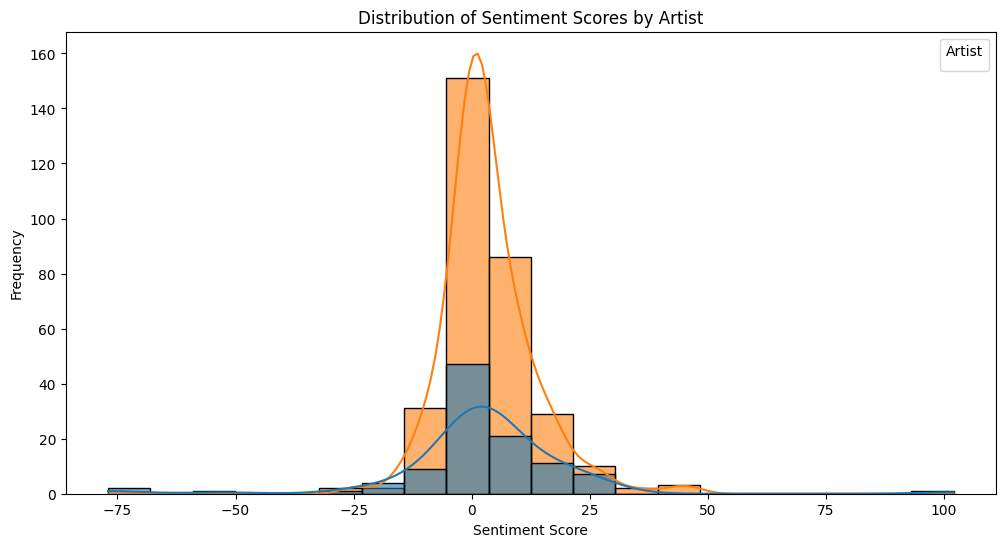

In [31]:
plt.figure(figsize=(12, 6))
sns.histplot(data=lyrics_df, x='sentiment_score', hue='artist', kde=True, bins=20, alpha=0.6)
plt.title('Distribution of Sentiment Scores by Artist')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(title='Artist')
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [36]:
# your code here

positive_emojis = {
    '😀', '😁', '😂', '😃', '😄', '😆', '😊', '😍', '🥳', '🎉'
}

negative_emojis = {
    '😞', '😢', '😠', '😡', '😔', '😩', '😫', '😕', '😤', '💔'
}

emoji_sentiment_dict = {emoji: 1 for emoji in positive_emojis}
emoji_sentiment_dict.update({emoji: -1 for emoji in negative_emojis})

def calculate_emoji_sentiment(twitter_data, emoji_sentiment_dict):
    artist_sentiment_scores = {}
    
    for artist, descriptions in twitter_data.items():
        total_score = 0
        emoji_count = 0
        
        for description in descriptions:
            for char in description:
                if char in emoji_sentiment_dict:
                    total_score += emoji_sentiment_dict[char]
                    emoji_count += 1
        
        # Calculate average sentiment score if there are emojis used
        average_score = total_score / emoji_count if emoji_count > 0 else 0
        artist_sentiment_scores[artist] = average_score

    return artist_sentiment_scores

emoji_sentiment_scores = calculate_emoji_sentiment(twitter_data, emoji_sentiment_dict)

# Check if the results are being generated
if emoji_sentiment_scores:
    for artist, score in emoji_sentiment_scores.items():
        print(f"Average sentiment score for {artist} based on Twitter descriptions: {score:.2f}")
else:
    print("No sentiment scores calculated. Please check the Twitter data.")

#print("Twitter Data (sample):", {artist: twitter_data[artist][:2] for artist in twitter_data})

Average sentiment score for cher_followers_data based on Twitter descriptions: 0.73
Average sentiment score for robynkonichiwa_followers_data based on Twitter descriptions: 0.74
Average sentiment score for cher_followers based on Twitter descriptions: 0.00
Average sentiment score for robynkonichiwa_followers based on Twitter descriptions: 0.00
Twitter Data (sample): {'cher_followers_data': ['screen_name\tname\tid\tlocation\tfollowers_count\tfriends_count\tdescription', 'hsmcnp\tCountry Girl\t35152213\t\t1302\t1014'], 'robynkonichiwa_followers_data': ['screen_name\tname\tid\tlocation\tfollowers_count\tfriends_count\tdescription', 'AngelxoArts\tAngelxo\t1424055675030806529\tZacatlan, Puebla, Mexico\t29\t535\t"I love chill" •Facebook / Instagram / SoundCloud: AngelxoArts• https://t.co/447okKLKzA…'], 'cher_followers': ['id', '35152213'], 'robynkonichiwa_followers': ['id', '1424055675030806529']}


Q: What is the average sentiment of your two artists? 

In [37]:
positive_emojis = {
    "😀": 1, "😁": 1, "😍": 1, "😃": 1, "😊": 1,
    "🎉": 1, "❤️": 1, "✨": 1, "👍": 1, "🌟": 1
}

negative_emojis = {
    "😢": -1, "😡": -1, "😠": -1, "😔": -1, "😞": -1,
    "💔": -1, "👎": -1, "😩": -1, "⚡": -1, "😱": -1
}

def calculate_average_sentiment(twitter_data, sentiment_dict):
    average_sentiment = {}
    
    for artist, descriptions in twitter_data.items():
        total_score = 0
        count = 0
        
        for description in descriptions:
            score = sum(sentiment_dict.get(char, 0) for char in description if char in sentiment_dict)
            total_score += score
            count += 1
            
        average_sentiment[artist] = total_score / count if count > 0 else 0  # Avoid division by zero

    return average_sentiment

# Calculate average sentiment for the two artists
average_sentiment = calculate_average_sentiment(twitter_data, {**positive_emojis, **negative_emojis})
print("Average Sentiment of Artists:", average_sentiment)

Average Sentiment of Artists: {'cher_followers_data': 0.01583506975561254, 'robynkonichiwa_followers_data': 0.009903089797501485, 'cher_followers': 0.0, 'robynkonichiwa_followers': 0.0}


A: The average sentiment of Cher is 0.016 while the average sentiment of Robyn is 0.01.

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

In [38]:
# Function to find the most popular emojis for each artist
def find_most_popular_emojis(twitter_data, emoji_dict):
    popular_emojis = {}
    
    for artist, descriptions in twitter_data.items():
        emoji_count = Counter()
        
        for description in descriptions:
            for char in description:
                if char in emoji_dict:
                    emoji_count[char] += 1
        
        if emoji_count:
            popular_emojis[artist] = {
                "most_positive": max((emoji for emoji in positive_emojis if emoji in emoji_count), 
                                     key=emoji_count.get, default=None),
                "most_negative": max((emoji for emoji in negative_emojis if emoji in emoji_count), 
                                     key=emoji_count.get, default=None)
            }

    return popular_emojis

popular_emojis = find_most_popular_emojis(twitter_data, {**positive_emojis, **negative_emojis})
print("Most Popular Emojis for Each Artist:", popular_emojis)

Most Popular Emojis for Each Artist: {'cher_followers_data': {'most_positive': '✨', 'most_negative': '⚡'}, 'robynkonichiwa_followers_data': {'most_positive': '✨', 'most_negative': '⚡'}}


A: The most positive emoji for Cher and Robyn was: ✨
The most negative emoji for Cher and Robyn was: ⚡